In [1]:
import netket as nk
import netket.experimental as nkx
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from time import time
import jax.numpy as jnp
from netket.operator.spin import sigmax, sigmay, sigmaz
import pickle
from flax.core import FrozenDict
import jax
from vmc_ex import VMC_ex

C:\Users\thejg\Desktop\Programming\projects39\lib\site-packages\netket\driver\vmc_common.py:33: FutureWarning: 

            `nk.driver.vmc_common is deprecated and the functionality removed.   

If you imported `nk.driver.vmc_common`, you must reimplement that functionality yourself.


  warn_deprecation(
C:\Users\thejg\Desktop\Programming\projects39\lib\site-packages\netket\utils\dispatch.py:25: FutureWarning: 
The variables `nk.utils.dispatch.{TrueT|FalseT|Bool}` are deprecated. Their usages
should instead be replaced by the following objects:

    `TrueT` should be replaced by `typing.Literal[True]`
    `FalseT` should be replaced by `typing.Literal[False]`
    `Bool` should be replaced by `bool`

  _warn_deprecation(


In [2]:
L = 10
n_iter = 3000
chain = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)
hilbert = nk.hilbert.Spin(s=1/2, total_sz=0, N=chain.n_nodes)
hamiltonian = nk.operator.Heisenberg(hilbert=hilbert, graph=chain, J=1)

In [3]:
rbm = nk.models.RBM(alpha=1)
sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=chain)
optimizer = nk.optimizer.Sgd(learning_rate=0.01)
sr = nk.optimizer.SR(diag_shift=0.1)
vstate = nk.vqs.MCState(sampler, rbm, n_samples=1008)
gs = nk.VMC(hamiltonian=hamiltonian, optimizer=optimizer, preconditioner=sr, variational_state=vstate)
start = time()
gs.run(n_iter=n_iter, out='./results/CHAINgs')
print(f'Time: {time()-start:.3f} seconds')

  0%|          | 0/3000 [00:00<?, ?it/s]

Time: 71.210 seconds


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Energy')]

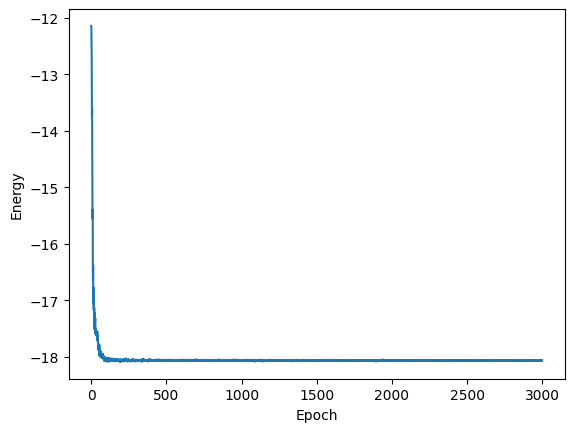

In [4]:
data_kitaev = json.load(open('./results/CHAINgs.log'))
figure, axes = plt.subplots(1, 1)
axes.plot(data_kitaev['Energy']['iters'], data_kitaev['Energy']['Mean'])
axes.set(xlabel='Epoch', ylabel='Energy')

In [5]:
def save_variational_state_parameters(state_params, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(state_params, file)

def load_variational_state_parameters(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)
    
def save_variational_state(state, file_path):
    save_variational_state_parameters(FrozenDict(state.parameters), file_path)
    
def load_variational_state(file_path, sampler, machine, **state_params):
    state = nk.vqs.MCState(sampler, machine, **state_params)
    state.init_parameters(jax.nn.initializers.normal(stddev=0.25))
    state.parameters = load_variational_state_parameters(file_path)
    return state

In [6]:
state_path = './Data/gs.json'
save_variational_state(vstate, state_path)
load_variational_state_parameters(state_path)

FrozenDict({
    Dense: {
        bias: Array([-2.51612692e-05,  5.87238614e-04,  7.01044564e-04, -4.63500605e-04,
               -2.55062324e-04, -1.82542197e-04, -1.02457500e-03, -1.20146918e-03,
                1.06287312e-05,  8.80564194e-04], dtype=float64),
        kernel: Array([[ 0.00699755, -0.02009676,  0.20511171,  0.00214353, -0.32487053,
                 0.06815876, -0.53171253, -0.91052086,  0.09935046,  0.21934399],
               [ 0.00221462, -0.14859947,  0.00600155, -0.05729882, -0.08916388,
                -0.06970372,  1.25888669,  0.14204338, -0.05111232,  0.35130475],
               [-0.08096217,  0.27294606,  0.12653903,  0.11460225,  0.00967582,
                -0.16644489, -0.25683488,  0.14547873,  0.27497915, -1.13828066],
               [ 0.10651447,  0.09900382, -0.23174953,  0.51944817, -0.02830751,
                 0.1973506 , -0.22273945,  0.07034216, -0.532473  ,  0.477473  ],
               [-0.13599191,  0.07013536, -0.02557225, -1.1449764 ,  0.01919

In [115]:
evals = nk.exact.lanczos_ed(hamiltonian, k=50, compute_eigenvectors=False)
evals

array([-18.06178542, -16.36882939, -15.08238974, -14.1731175 ,
       -14.1731175 , -12.98465967, -12.98465967, -11.90372748,
       -11.5649444 , -11.5649444 , -11.5451477 , -11.5451477 ,
       -11.1219604 , -11.1219604 , -11.07053954, -11.07053954,
       -10.05719792, -10.05719792,  -9.95065143,  -9.95065143,
        -9.75526128,  -9.33697274,  -9.28133851,  -9.28133851,
        -8.51121585,  -8.51121585,  -8.38485174,  -8.11565393,
        -8.11565393,  -8.07648178,  -7.84340543,  -7.84340543,
        -7.7879458 ,  -7.7879458 ,  -7.71941018,  -7.71941018,
        -7.09134594,  -7.09134594,  -6.95446858,  -6.95446858,
        -6.87061307,  -6.87061307,  -6.70770301,  -6.70770301,
        -6.62577457,  -6.60829875,  -6.60829875,  -6.19231518,
        -6.19231518,  -6.1672449 ])

In [8]:
rbm = nk.models.RBM(alpha=1)
sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=chain)
optimizer = nk.optimizer.Sgd(learning_rate=0.01)
sr = nk.optimizer.SR(diag_shift=0.1)
vstate = nk.vqs.MCState(sampler, rbm, n_samples=2000)
energies = [load_variational_state(state_path, sampler, rbm, n_samples=1008)]

In [9]:
gs = VMC_ex(hamiltonian=hamiltonian, 
            optimizer=optimizer, 
            preconditioner=sr, 
            variational_state=vstate,
            state_list=energies,
            shift_list=[6])

In [10]:
start = time()
gs.run(n_iter=n_iter, out='./results/CHAINex')
print(f'Time: {time()-start:.3f} seconds')

  0%|          | 0/3000 [00:00<?, ?it/s]

Time: 162.834 seconds


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Energy')]

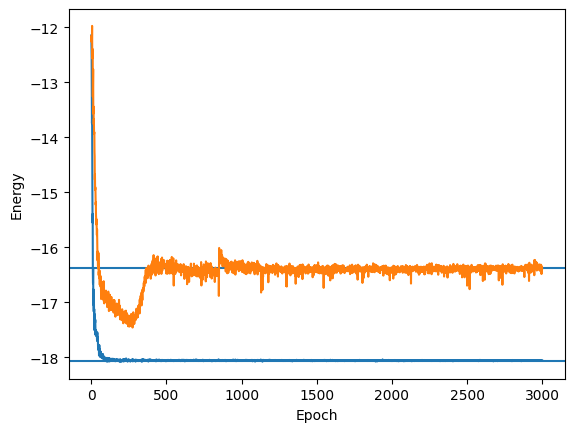

In [11]:
data_kitaev_ex = json.load(open('./results/CHAINex.log'))
figure, axes = plt.subplots(1, 1)
axes.axhline(y=evals[0])
axes.axhline(y=evals[1])
axes.plot(data_kitaev['Energy']['iters'], data_kitaev['Energy']['Mean'])
axes.plot(data_kitaev_ex['Energy']['iters'], data_kitaev_ex['Energy']['Mean'])
axes.set(xlabel='Epoch', ylabel='Energy')

In [12]:
ex_path = './Data/ex.json'
save_variational_state(vstate, ex_path)

In [68]:
rbm = nk.models.RBM(alpha=1)
sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=chain)
optimizer = nk.optimizer.Sgd(learning_rate=0.01)
sr = nk.optimizer.SR(diag_shift=0.1)
vstate = nk.vqs.MCState(sampler, rbm, n_samples=2000)
energies = [load_variational_state(state_path, sampler, rbm, n_samples=1008),
            load_variational_state(ex_path, sampler, rbm, n_samples=2000)]

In [69]:
gs = VMC_ex(hamiltonian=hamiltonian, 
            optimizer=optimizer, 
            preconditioner=sr, 
            variational_state=vstate,
            state_list=energies,
            shift_list=[12, 12])

In [70]:
start = time()
gs.run(n_iter=n_iter, out='./results/CHAIN2ex')
print(f'Time: {time()-start:.3f} seconds')

  0%|          | 0/3000 [00:00<?, ?it/s]

Time: 177.114 seconds


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Energy')]

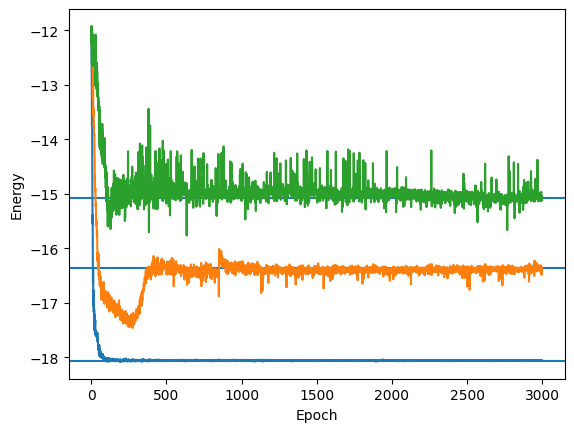

In [71]:
data_kitaev_2ex = json.load(open('./results/CHAIN2ex.log'))
figure, axes = plt.subplots(1, 1)
axes.axhline(y=evals[0])
axes.axhline(y=evals[1])
axes.axhline(y=evals[2])
axes.plot(data_kitaev['Energy']['iters'], data_kitaev['Energy']['Mean'])
axes.plot(data_kitaev_ex['Energy']['iters'], data_kitaev_ex['Energy']['Mean'])
axes.plot(data_kitaev_2ex['Energy']['iters'], data_kitaev_2ex['Energy']['Mean'])
axes.set(xlabel='Epoch', ylabel='Energy')

In [73]:
ex2_path = './Data/ex2.json'
save_variational_state(vstate, ex2_path)

In [123]:
rbm = nk.models.RBM(alpha=1)
sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=chain)
optimizer = nk.optimizer.Sgd(learning_rate=0.02)
sr = nk.optimizer.SR(diag_shift=0.1)
vstate = nk.vqs.MCState(sampler, rbm, n_samples=2000)
energies = [load_variational_state(state_path, sampler, rbm, n_samples=1008),
            load_variational_state(ex_path, sampler, rbm, n_samples=2000),
            load_variational_state(ex2_path, sampler, rbm, n_samples=2000)]
gs = VMC_ex(hamiltonian=hamiltonian, 
            optimizer=optimizer, 
            preconditioner=sr, 
            variational_state=vstate,
            state_list=energies,
            shift_list=[7, 7, 7])
start = time()
gs.run(n_iter=3000, out='./results/CHAIN3ex')
print(f'Time: {time()-start:.3f} seconds')

  0%|          | 0/3000 [00:00<?, ?it/s]

Time: 236.254 seconds


In [125]:
ex3_path = './Data/ex3.json'
save_variational_state(vstate, ex3_path)

In [149]:
rbm = nk.models.RBM(alpha=1)
sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=chain)
optimizer = nk.optimizer.Sgd(learning_rate=0.02)
sr = nk.optimizer.SR(diag_shift=0.5)
vstate = nk.vqs.MCState(sampler, rbm, n_samples=2000)
energies = [load_variational_state(state_path, sampler, rbm, n_samples=1008),
            load_variational_state(ex_path, sampler, rbm, n_samples=2000),
            load_variational_state(ex2_path, sampler, rbm, n_samples=2000),
            load_variational_state(ex3_path, sampler, rbm, n_samples=2000)]
gs = VMC_ex(hamiltonian=hamiltonian, 
            optimizer=optimizer, 
            preconditioner=sr, 
            variational_state=vstate,
            state_list=energies,
            shift_list=[13, 13, 13 , 13])
start = time()
gs.run(n_iter=3000, out='./results/CHAIN4ex')
print(f'Time: {time()-start:.3f} seconds')

  0%|          | 0/3000 [00:00<?, ?it/s]

Time: 292.572 seconds


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Energy')]

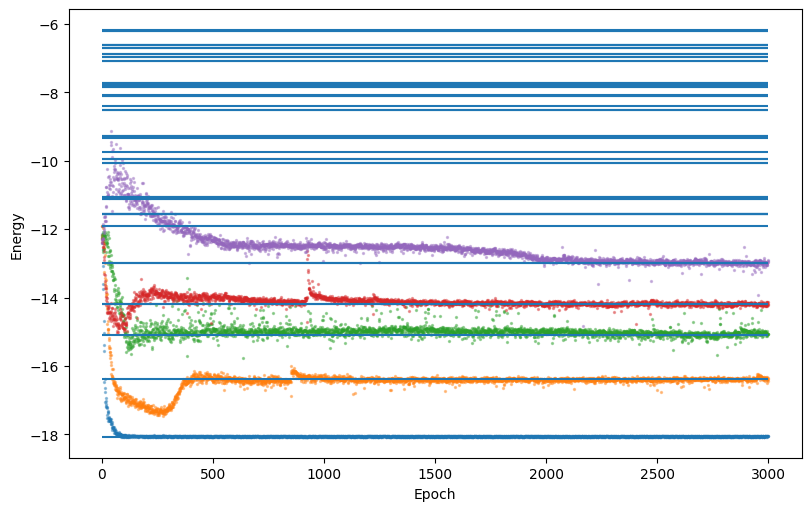

In [160]:
data_kitaev_3ex = json.load(open('./results/CHAIN3ex.log'))
data_kitaev_4ex = json.load(open('./results/CHAIN4ex.log'))
figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 5))
scatter_params = {'s': 2, 'alpha': 0.4}
axes.hlines(evals, 0, 3000)
axes.scatter(data_kitaev['Energy']['iters'], data_kitaev['Energy']['Mean'], **scatter_params)
axes.scatter(data_kitaev_ex['Energy']['iters'], data_kitaev_ex['Energy']['Mean'], **scatter_params)
axes.scatter(data_kitaev_2ex['Energy']['iters'], data_kitaev_2ex['Energy']['Mean'], **scatter_params)
axes.scatter(data_kitaev_3ex['Energy']['iters'], data_kitaev_3ex['Energy']['Mean'], **scatter_params)
axes.scatter(data_kitaev_4ex['Energy']['iters'], data_kitaev_4ex['Energy']['Mean'], **scatter_params)
axes.set(xlabel='Epoch', ylabel='Energy')

checking degeneracy in kitaev model